<span style='color:darkcyan'><font size="3">_Juan Sebastian Deslarzes_</font></span><br>
<span style='color:darkcyan'><font size="3">_Chloé De Ancos_</font></span><br>
<span style='color:darkcyan'><font size="3">_Anaïs Burrus_</font></span><br>
<span style='color:darkcyan'><font size="3">_Margot Chapot_</font></span><br>
<span style='color:darkcyan'><font size="3">_Eva Sarlin_</font></span><br>

<span style='color:steelblue'><font size="6">__Notebook 1 : use of one pipeline for each feature seperately__</font></span><br>

<span style='color:mediumpurple'><font size="6">__Importing packages__</font></span><br>

In [140]:
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd
import numpy as np
from skimage import io
from IPython import display
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
output_notebook()
import seaborn as sns
sns.set(color_codes=True)

Loading BokehJS ...

In [141]:
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from collections import Counter 
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
import pickle
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from scipy.sparse import csr_matrix

from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import VotingClassifier

from evolutionary_search import EvolutionaryAlgorithmSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import Perceptron

import string

[nltk_data] Downloading package stopwords to /Users/epfl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<span style='color:mediumpurple'><font size="6">__Data Loading__</font></span><br>

In [142]:
sample_submission_url = 'https://raw.githubusercontent.com/esarlin/Challenge-2-CDAW/main/sitc-challenge2-2022/sample_submission.csv'
test_nolabel_url= 'https://raw.githubusercontent.com/esarlin/Challenge-2-CDAW/main/sitc-challenge2-2022/test_nolabel.csv'
train_url = 'https://raw.githubusercontent.com/esarlin/Challenge-2-CDAW/main/sitc-challenge2-2022/train.csv'

sample_submission = pd.read_csv(sample_submission_url)
test_nolabel = pd.read_csv(test_nolabel_url)
train = pd.read_csv(train_url)

<span style='color:mediumpurple'><font size="6">__Data Visualization__</font></span><br>

In [143]:
train.head()

,id,label,statement,subject,speaker,speaker_job,state_info,party_affiliation
0,81f884c64a7,1,China is in the South China Sea and (building)...,"china,foreign-policy,military",donald-trump,President-Elect,New York,republican
1,30c2723a188,0,With the resources it takes to execute just ov...,health-care,chris-dodd,U.S. senator,Connecticut,democrat
2,6936b216e5d,0,The (Wisconsin) governor has proposed tax give...,"corporations,pundits,taxes,abc-news-week",donna-brazile,Political commentator,"Washington, D.C.",democrat
3,b5cd9195738,1,Says her representation of an ex-boyfriend who...,"candidates-biography,children,ethics,families,...",rebecca-bradley,NaN,NaN,none
4,84f8dac7737,0,At protests in Wisconsin against proposed coll...,"health-care,labor,state-budget",republican-party-wisconsin,NaN,Wisconsin,republican


In [144]:
print('Data train dimensions : ', train.shape)
print('Unique values for label : ', train['label'].unique())
print("Number of unique values for statement: ", train['statement'].unique().size)
print("Number of unique values for subject: ", (train['subject'].unique()).size)
print("Number of unique values for speaker: ", (train['speaker'].unique()).size)
print("Number of unique values for speaker job: ", (train['speaker_job'].unique()).size)
print("Number of unique values for state information: ", (train['state_info'].unique()).size)
print("Number of unique values for party affiliation: ", (train['party_affiliation'].unique()).size)

Data train dimensions :  (8950, 8)
Unique values for label :  [1 0]
Number of unique values for statement:  8939
Number of unique values for subject:  3409
Number of unique values for speaker:  2634
Number of unique values for speaker job:  1092
Number of unique values for state information:  80
Number of unique values for party affiliation:  24


<AxesSubplot:xlabel='label', ylabel='party_affiliation'>

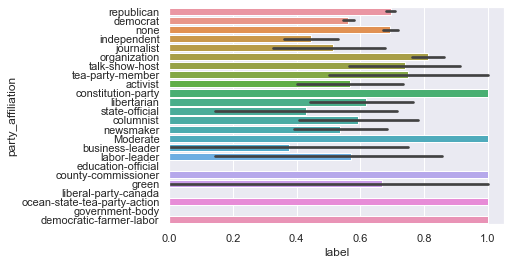

In [145]:
sns.barplot(x='label', y='party_affiliation', data=train)

This graph represents the mean value of the label for each party affiliation.

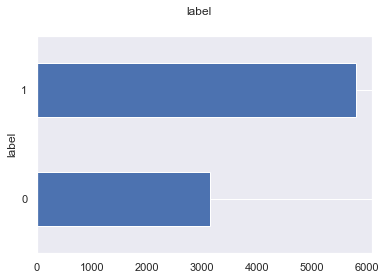

In [146]:
import matplotlib.pyplot as plt
x = "label"
fig, ax = plt.subplots()
fig.suptitle(x, fontsize=12)
train[x].reset_index().groupby(x).count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

The data is unbalanced, there are a lot more false claims than true ones.

In [147]:
train['word_count'] = train["statement"].apply(lambda x: len(str(x).split(" ")))
train['char_count'] = train["statement"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
train['sentence_count'] = train["statement"].apply(lambda x: len(str(x).split(".")))
train['avg_word_length'] = train['char_count'] / train['word_count']
train['avg_sentence_lenght'] = train['word_count'] / train['sentence_count']
train.head()

,id,label,statement,subject,speaker,speaker_job,state_info,party_affiliation,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght
0,81f884c64a7,1,China is in the South China Sea and (building)...,"china,foreign-policy,military",donald-trump,President-Elect,New York,republican,21,96,2,4.571429,10.5
1,30c2723a188,0,With the resources it takes to execute just ov...,health-care,chris-dodd,U.S. senator,Connecticut,democrat,30,135,2,4.500000,15.0
2,6936b216e5d,0,The (Wisconsin) governor has proposed tax give...,"corporations,pundits,taxes,abc-news-week",donna-brazile,Political commentator,"Washington, D.C.",democrat,9,60,2,6.666667,4.5
3,b5cd9195738,1,Says her representation of an ex-boyfriend who...,"candidates-biography,children,ethics,families,...",rebecca-bradley,NaN,NaN,none,25,111,2,4.440000,12.5
4,84f8dac7737,0,At protests in Wisconsin against proposed coll...,"health-care,labor,state-budget",republican-party-wisconsin,NaN,Wisconsin,republican,20,122,2,6.100000,10.0


Now the dataframe has additional features such as word_count, char_count, sentence_count, avg_word_length and avg_sentence_length. 

/Users/epfl/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/epfl/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/epfl/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simil

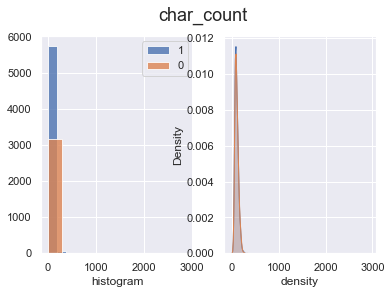

In [148]:
x, y = "char_count", "label"
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle(x, fontsize=18)
for i in train[y].unique():
    sns.distplot(train[train[y]==i][x], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[0])
    sns.distplot(train[train[y]==i][x], hist=False, kde=True, 
                 kde_kws={"shade":True}, axlabel="density",   
                 ax=ax[1])
ax[0].grid(True)
ax[0].legend(train[y].unique())
ax[1].grid(True)
plt.show()

The 2 categories (false or true statement) have a similar density distribution (density graph). Since there is no shift between the true and false histogram bars it seems this feature would not be very useful to help predict the labels (histogram graph).


<span style='color:steelblue'><font size="5">__Sentiment analysis__</font></span><br>

The sentiment property returns a namedtuple of the form Sentiment (polarity, subjectivity). The polarity score is a float within the range [-1.0, 1.0] where 1 means a positive statement and -1 a negative statement. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [149]:
## for sentiment
from textblob import TextBlob

train["polarity"] = train["statement"].apply(lambda x: 
                   TextBlob(x).sentiment.polarity)
train["subjectivity"] = train["statement"].apply(lambda x: 
                   TextBlob(x).sentiment.subjectivity)
train.head()

,id,label,statement,subject,speaker,speaker_job,state_info,party_affiliation,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,polarity,subjectivity
0,81f884c64a7,1,China is in the South China Sea and (building)...,"china,foreign-policy,military",donald-trump,President-Elect,New York,republican,21,96,2,4.571429,10.5,-0.100000,0.100000
1,30c2723a188,0,With the resources it takes to execute just ov...,health-care,chris-dodd,U.S. senator,Connecticut,democrat,30,135,2,4.500000,15.0,0.000000,0.000000
2,6936b216e5d,0,The (Wisconsin) governor has proposed tax give...,"corporations,pundits,taxes,abc-news-week",donna-brazile,Political commentator,"Washington, D.C.",democrat,9,60,2,6.666667,4.5,0.000000,0.000000
3,b5cd9195738,1,Says her representation of an ex-boyfriend who...,"candidates-biography,children,ethics,families,...",rebecca-bradley,NaN,NaN,none,25,111,2,4.440000,12.5,0.000000,0.076923
4,84f8dac7737,0,At protests in Wisconsin against proposed coll...,"health-care,labor,state-budget",republican-party-wisconsin,NaN,Wisconsin,republican,20,122,2,6.100000,10.0,-0.088095,0.635714


/Users/epfl/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/epfl/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/epfl/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simil

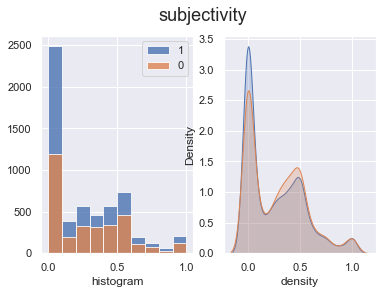

In [150]:
x, y = "subjectivity", "label"
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle(x, fontsize=18)
for i in train[y].unique():
    sns.distplot(train[train[y]==i][x], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[0])
    sns.distplot(train[train[y]==i][x], hist=False, kde=True, 
                 kde_kws={"shade":True}, axlabel="density",   
                 ax=ax[1])
ax[0].grid(True)
ax[0].legend(train[y].unique())
ax[1].grid(True)
plt.show()

<span style='color:mediumpurple'><font size="6">__Feature engineering__</font></span><br>

In [151]:
data_features = train.copy()[["statement", "subject", "speaker","speaker_job","state_info", "party_affiliation"]]
test_features = test_nolabel.copy()[["statement", "subject", "speaker","speaker_job","state_info","party_affiliation"]]
target = train.label.values

<span style='color:steelblue'><font size="5">__Speaker_job and state_info processing__</font></span><br>

In [152]:
data_features['speaker_job']= data_features['speaker_job'].fillna('u.s. senator')
test_features['speaker_job']= test_features['speaker_job'].fillna('u.s. senator')
data_features['state_info']= data_features['state_info'].fillna('unknown')
test_features['state_info']= test_features['state_info'].fillna('unknown')

<span style='color:steelblue'><font size="5">__New feature: party group__</font></span><br>

We have chosen to add a new feature called "party_group" in which we have separated the feature "party_affiliation" into three groups : 0 which corresponds to republican, 1 to democrats and 2 to others.

In [153]:
data_features['party_group'] = data_features['party_affiliation']
test_features['party_group'] = test_features['party_affiliation']

In [154]:
party = data_features.groupby('party_affiliation').size()
print(f'Names of the party_affiliations of the speakers, and how many of them are affiliated: \n{party}')
party_test = test_features.groupby('party_affiliation').size()
print(f'Names of the party_affiliations of the speakers, and how many of them are affiliated: \n{party_test}')

Names of the party_affiliations of the speakers, and how many of them are affiliated: 
party_affiliation
Moderate                           1
activist                          30
business-leader                    8
columnist                         32
constitution-party                 2
county-commissioner                1
democrat                        2898
democratic-farmer-labor            1
education-official                 2
government-body                    1
green                              3
independent                      130
journalist                        37
labor-leader                       7
liberal-party-canada               1
libertarian                       34
newsmaker                         41
none                            1531
ocean-state-tea-party-action       1
organization                     197
republican                      3947
state-official                    14
talk-show-host                    23
tea-party-member                   8
dtype: 

In [155]:
#Encode new feature 
data_features.loc[data_features["party_group"] == "republican", "party_group"] = 0
data_features.loc[data_features["party_group"] == "democrat", "party_group"] = 1
data_features.loc[data_features["party_group"] == "none", "party_group"] = 2
data_features.loc[data_features["party_group"] == "independent", "party_group"] = 2
data_features.loc[data_features["party_group"] == "journalist", "party_group"] = 2
data_features.loc[data_features["party_group"] == "organization", "party_group"] = 2
data_features.loc[data_features["party_group"] == "talk-show-host", "party_group"] = 2
data_features.loc[data_features["party_group"] == "tea-party-member", "party_group"] = 0
data_features.loc[data_features["party_group"] == "activist", "party_group"] = 2
data_features.loc[data_features["party_group"] == "constitution-party", "party_group"] = 0
data_features.loc[data_features["party_group"] == "libertarian", "party_group"] = 0
data_features.loc[data_features["party_group"] == "state-official", "party_group"] = 2
data_features.loc[data_features["party_group"] == "columnist", "party_group"] = 2
data_features.loc[data_features["party_group"] == "newsmaker", "party_group"] = 2
data_features.loc[data_features["party_group"] == "Moderate", "party_group"] = 2
data_features.loc[data_features["party_group"] == "county-commissioner", "party_group"] = 2
data_features.loc[data_features["party_group"] == "green", "party_group"] = 1
data_features.loc[data_features["party_group"] == "liberal-party-canada", "party_group"] = 0
data_features.loc[data_features["party_group"] == "ocean-state-tea-party-action", "party_group"] = 1
data_features.loc[data_features["party_group"] == "government-body", "party_group"] = 2
data_features.loc[data_features["party_group"] == "democratic-farmer-labor", "party_group"] = 1
data_features.loc[data_features["party_group"] == "business-leader", "party_group"] = 0
data_features.loc[data_features["party_group"] == "education-official", "party_group"] = 0
data_features.loc[data_features["party_group"] == "labor-leader", "party_group"] = 1

test_features.loc[test_features["party_group"] == "republican", "party_group"] = 0
test_features.loc[test_features["party_group"] == "democrat", "party_group"] = 1
test_features.loc[test_features["party_group"] == "none", "party_group"] = 2
test_features.loc[test_features["party_group"] == "independent", "party_group"] = 2
test_features.loc[test_features["party_group"] == "journalist", "party_group"] = 2
test_features.loc[test_features["party_group"] == "organization", "party_group"] = 2
test_features.loc[test_features["party_group"] == "talk-show-host", "party_group"] = 2
test_features.loc[test_features["party_group"] == "tea-party-member", "party_group"] = 0
test_features.loc[test_features["party_group"] == "activist", "party_group"] = 2
test_features.loc[test_features["party_group"] == "constitution-party", "party_group"] = 0
test_features.loc[test_features["party_group"] == "libertarian", "party_group"] = 0
test_features.loc[test_features["party_group"] == "state-official", "party_group"] = 2
test_features.loc[test_features["party_group"] == "columnist", "party_group"] = 2
test_features.loc[test_features["party_group"] == "newsmaker", "party_group"] = 2
test_features.loc[test_features["party_group"] == "Moderate", "party_group"] = 2
test_features.loc[test_features["party_group"] == "county-commissioner", "party_group"] = 2
test_features.loc[test_features["party_group"] == "green", "party_group"] = 1
test_features.loc[test_features["party_group"] == "liberal-party-canada", "party_group"] = 0
test_features.loc[test_features["party_group"] == "ocean-state-tea-party-action", "party_group"] = 1
test_features.loc[test_features["party_group"] == "government-body", "party_group"] = 2
test_features.loc[test_features["party_group"] == "democratic-farmer-labor", "party_group"] = 1
test_features.loc[test_features["party_group"] == "business-leader", "party_group"] = 0
test_features.loc[test_features["party_group"] == "education-official", "party_group"] = 0
test_features.loc[test_features["party_group"] == "labor-leader", "party_group"] = 1

In [156]:
data_features.head()

,statement,subject,speaker,speaker_job,state_info,party_affiliation,party_group
0,China is in the South China Sea and (building)...,"china,foreign-policy,military",donald-trump,President-Elect,New York,republican,0
1,With the resources it takes to execute just ov...,health-care,chris-dodd,U.S. senator,Connecticut,democrat,1
2,The (Wisconsin) governor has proposed tax give...,"corporations,pundits,taxes,abc-news-week",donna-brazile,Political commentator,"Washington, D.C.",democrat,1
3,Says her representation of an ex-boyfriend who...,"candidates-biography,children,ethics,families,...",rebecca-bradley,u.s. senator,unknown,none,2
4,At protests in Wisconsin against proposed coll...,"health-care,labor,state-budget",republican-party-wisconsin,u.s. senator,Wisconsin,republican,0


We created an array (y_7) with the values of party_group which we will further use in the creation of a sparse matrix

In [157]:
y_7 = np.array(data_features["party_group"])
y_p7 = np.array(test_features["party_group"])

<span style='color:steelblue'><font size="5">__New feature: sentence length__</font></span><br>

/Users/epfl/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/epfl/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/epfl/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simil

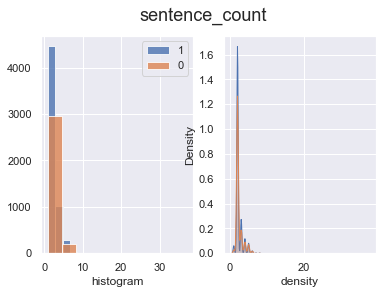

In [158]:
x, y = "sentence_count", "label"
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle(x, fontsize=18)
for i in train[y].unique():
    sns.distplot(train[train[y]==i][x], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[0])
    sns.distplot(train[train[y]==i][x], hist=False, kde=True, 
                 kde_kws={"shade":True}, axlabel="density",   
                 ax=ax[1])
ax[0].grid(True)
ax[0].legend(train[y].unique())
ax[1].grid(True)
plt.show()

From these graphics there is no shift on the histogram between the truth and the lies this features will not be of big help to predict the labels thus we did not implement it.

<span style='color:steelblue'><font size="5">__New feature: subjectivity__</font></span><br>

In [159]:
from textblob import TextBlob

data_features["subjectivity"] = data_features["statement"].apply(lambda x: 
                   TextBlob(x).sentiment.subjectivity)
test_features["subjectivity"] = test_features["statement"].apply(lambda x: 
                   TextBlob(x).sentiment.subjectivity)
data_features.head()

,statement,subject,speaker,speaker_job,state_info,party_affiliation,party_group,subjectivity
0,China is in the South China Sea and (building)...,"china,foreign-policy,military",donald-trump,President-Elect,New York,republican,0,0.100000
1,With the resources it takes to execute just ov...,health-care,chris-dodd,U.S. senator,Connecticut,democrat,1,0.000000
2,The (Wisconsin) governor has proposed tax give...,"corporations,pundits,taxes,abc-news-week",donna-brazile,Political commentator,"Washington, D.C.",democrat,1,0.000000
3,Says her representation of an ex-boyfriend who...,"candidates-biography,children,ethics,families,...",rebecca-bradley,u.s. senator,unknown,none,2,0.076923
4,At protests in Wisconsin against proposed coll...,"health-care,labor,state-budget",republican-party-wisconsin,u.s. senator,Wisconsin,republican,0,0.635714


In [160]:
data_features.loc[data_features['subjectivity'] >= 0.8, 'subjectivityRange'] = int(0)
data_features.loc[(data_features['subjectivity'] < 0.8) & (data_features['subjectivity'] >= 0.6), 'subjectivityRange'] = int(1)
data_features.loc[(data_features['subjectivity'] < 0.6) & (data_features['subjectivity'] >= 0.4), 'subjectivityRange'] = int(2)
data_features.loc[(data_features['subjectivity'] < 0.4) & (data_features['subjectivity'] >= 0.2), 'subjectivityRange'] = int(3)
data_features.loc[data_features['subjectivity'] < 0.2, 'subjectivityRange'] = int(4)
data_features.head()


,statement,subject,speaker,speaker_job,state_info,party_affiliation,party_group,subjectivity,subjectivityRange
0,China is in the South China Sea and (building)...,"china,foreign-policy,military",donald-trump,President-Elect,New York,republican,0,0.100000,4.0
1,With the resources it takes to execute just ov...,health-care,chris-dodd,U.S. senator,Connecticut,democrat,1,0.000000,4.0
2,The (Wisconsin) governor has proposed tax give...,"corporations,pundits,taxes,abc-news-week",donna-brazile,Political commentator,"Washington, D.C.",democrat,1,0.000000,4.0
3,Says her representation of an ex-boyfriend who...,"candidates-biography,children,ethics,families,...",rebecca-bradley,u.s. senator,unknown,none,2,0.076923,4.0
4,At protests in Wisconsin against proposed coll...,"health-care,labor,state-budget",republican-party-wisconsin,u.s. senator,Wisconsin,republican,0,0.635714,1.0


In [161]:
test_features.loc[test_features['subjectivity'] >= 0.8, 'subjectivityRange'] = int(0)
test_features.loc[(test_features['subjectivity'] < 0.8) & (test_features['subjectivity'] >= 0.6), 'subjectivityRange'] = int(1)
test_features.loc[(test_features['subjectivity'] < 0.6) & (test_features['subjectivity'] >= 0.4), 'subjectivityRange'] = int(2)
test_features.loc[(test_features['subjectivity'] < 0.4) & (test_features['subjectivity'] >= 0.2), 'subjectivityRange'] = int(3)
test_features.loc[test_features['subjectivity'] < 0.2, 'subjectivityRange'] = int(4)
test_features.head()



,statement,subject,speaker,speaker_job,state_info,party_affiliation,party_group,subjectivity,subjectivityRange
0,Five members of [the Common Cause Georgia] boa...,"campaign-finance,ethics,government-regulation",kasim-reed,u.s. senator,unknown,democrat,1,0.500000,2.0
1,Theres no negative advertising in my campaign ...,elections,bill-mccollum,u.s. senator,Florida,republican,0,0.400000,2.0
2,Leticia Van de Putte voted to give illegal imm...,"health-care,immigration,public-health",dan-patrick,Lieutenant governor-elect,Texas,republican,0,0.712500,1.0
3,Fiorinas plan would mean slashing Social Secur...,"federal-budget,medicare,social-security",barbara-boxer,U.S. Senator,California,democrat,1,0.377083,3.0
4,"By the end of his first term, President Obama ...","federal-budget,new-hampshire-2012",mitt-romney,Former governor,Massachusetts,republican,0,0.177778,4.0


In [162]:
y_8 = np.array(data_features["subjectivityRange"])
y_p8 = np.array(test_features["subjectivityRange"])

We created an array (y_8) with the values of subjectivityRange which we will further use in the creation of a sparse matrix.

<div class="alert alert-block alert-info">
    <span style='color:darkblue'><font size="4"><b>CONCLUSION DATA VISUALIZATION</b></font></span><br><br> <span style='color:black'> In conclusion we have a training dataset with 8950 instances and 8 features and a test dataset with 3836 instances. We have added 2 features, one feature called "party_group" and one called "subjectivity". The column "label" is the label to be predicted which we will now do using nlp processing and various ML algorithms.
     </span>
</div>

<span style='color:mediumpurple'><font size="6">__NLP algorithms__</font></span><br>

In [163]:
X1 = data_features['statement'].values
X2 = data_features['subject'].values
X3 = data_features['speaker'].values
X4 = data_features['speaker_job'].values
X5 = data_features['state_info'].values
X6 = data_features['party_affiliation'].values
y = train['label'].values


X_test1 = test_features['statement'].values
X_test2 = test_features['subject'].values
X_test3 = test_features['speaker'].values
X_test4 = test_features['speaker_job'].values
X_test5 = test_features['state_info'].values
X_test6 = test_features['party_affiliation'].values

In our transformers will perform the following tasks:
- split the sentences 
- split the words
- remove stop words 
- remove the punctuation
- modify capital letters in lowercases
- remove morphological affixes with stemmers, leaving only the word stem 
- we also perform POS tagging which assigns a grammatical category to a word
- transform the text into numerical feature vectors using vectorizer

In [164]:
# Generic Transformer 
class GenericTransformer(BaseEstimator, TransformerMixin):

    def transform(self, X, y=None):
        return do_something_to(X, self.vars)  # where the actual feature extraction happens

    def fit(self, X, y=None):
        return self  # used if the feature requires training, for example, clustering

In [165]:
class LexicalStats (BaseEstimator, TransformerMixin):
    """Extract lexical features from each document"""
    
    def number_sentences(self, doc):
        sentences = sent_tokenize(doc, language='english')
        return len(sentences)

    def fit(self, x, y=None):
        return self

    def transform(self, docs):
        return [{'length': len(doc),
                 'num_sentences': self.number_sentences(doc)}
                for doc in docs]

In [166]:
def custom_tokenizer(words):
    """Preprocessing tokens as seen in the lexical notebook"""
    tokens = word_tokenize(words.lower())
    porter = PorterStemmer()
    lemmas = [porter.stem(t) for t in tokens]
    stoplist = stopwords.words('english')
    lemmas_clean = [w for w in lemmas if w not in stoplist]
    punctuation = set(string.punctuation)
    lemmas_punct = [w for w in lemmas_clean if  w not in punctuation]
    return lemmas_punct

In [167]:
class PosStats(BaseEstimator, TransformerMixin):
    """Obtain number of tokens with POS categories"""

    def stats(self, doc):
        tokens = custom_tokenizer(doc)
        tagged = pos_tag(tokens, tagset='universal')
        counts = Counter(tag for word,tag in tagged)
        total = sum(counts.values())
        #copy tags so that we return always the same number of features
        pos_features = {'NOUN': 0, 'ADJ': 0, 'VERB': 0, 'ADV': 0, 'CONJ': 0, 
                        'ADP': 0, 'PRON':0, 'NUM': 0}
        
        pos_dic = dict((tag, float(count)/total) for tag,count in counts.items())
        for k in pos_dic:
            if k in pos_features:
                pos_features[k] = pos_dic[k]
        return pos_features
    
    def transform(self, docs, y=None):
        return [self.stats(doc) for doc in docs]
    
    def fit(self, docs, y=None):
        """Returns `self` unless something different happens in train and test"""
        return self

In [168]:
ngrams_featurizer = Pipeline([
  ('count_vectorizer',  CountVectorizer(ngram_range = (1, 3), encoding = 'ISO-8859-1', 
                                        tokenizer=custom_tokenizer)),
  ('tfidf_transformer', TfidfTransformer())
])

<span style='color:steelblue'><font size="5">__Pipelines for each feature__</font></span><br>

In this section we will use pipelines with the desired features to extract (lexical...). We applied one pipeline on every feature of the dataset one at a time. In the next section we will use the predictions from these pipelines and combine them together to predict the label of the test dataset.


In [169]:
#feature "statement"
pipeline1 = Pipeline([
       ('features', FeatureUnion([
                    ('lexical_stats', Pipeline([
                                ('stats', LexicalStats()),
                                ('vectors', DictVectorizer())
                            ])),
                    ('words', TfidfVectorizer(tokenizer=custom_tokenizer)),
                    ('ngrams', ngrams_featurizer),
                    ('pos_stats', Pipeline([
                                ('pos_stats', PosStats()),
                                ('vectors', DictVectorizer())
                            ])),
                    ('lda', Pipeline([ 
                                ('count', CountVectorizer(tokenizer=custom_tokenizer)),
                                ('lda',  LatentDirichletAllocation(n_components=4, max_iter=5,
                                                       learning_method='online', 
                                                       learning_offset=50.,
                                                       random_state=0))
                            ])),
                ])),
         ('clf', MultinomialNB(alpha=.0001))
    ])


#Train the pipeline with values from train dataset
pipeline1.fit(X1,y)

#Predict the labels using the values from the train dataset
y_1 = pipeline1.predict(X1)

#Predict the labels using the values from the test dataset
y_p1 = pipeline1.predict(X_test1)

# Accuracy using KFold validation
cv = KFold(2, shuffle=True, random_state=33)
scores = cross_val_score(pipeline1, X1, y, cv=cv)
print("Scores in every iteration", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores in every iteration [0.59821229 0.58703911]
Accuracy: 0.59 (+/- 0.01)


In [170]:
#feature "subject"
pipeline2 = Pipeline([
       ('features', FeatureUnion([
                    ('lexical_stats', Pipeline([
                                ('stats', LexicalStats()),
                                ('vectors', DictVectorizer())
                            ])),
                    ('words', TfidfVectorizer(tokenizer=custom_tokenizer)),
                    ('ngrams', ngrams_featurizer),
                    ('pos_stats', Pipeline([
                                ('pos_stats', PosStats()),
                                ('vectors', DictVectorizer())
                            ])),
                    ('lda', Pipeline([ 
                                ('count', CountVectorizer(tokenizer=custom_tokenizer)),
                                ('lda',  LatentDirichletAllocation(n_components=4, max_iter=5,
                                                       learning_method='online', 
                                                       learning_offset=50.,
                                                       random_state=0))
                            ])),
                ])),
       ('clf', MultinomialNB(alpha=.0001))
    ])

#Train the pipeline with values from train dataset
pipeline2.fit(X2,y)

#Predict the labels using the values from the test dataset
y_p2 = pipeline2.predict(X_test2)

#Predict the labels using the values from the train dataset
y_2=pipeline2.predict(X2)

# Accuracy using KFold validation
cv = KFold(2, shuffle=True, random_state=33)
scores = cross_val_score(pipeline2, X2, y, cv=cv)
print("Scores in every iteration", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores in every iteration [0.57765363 0.5803352 ]
Accuracy: 0.58 (+/- 0.00)


In [171]:
#feature "speaker"
pipeline3 = Pipeline([
       ('features', FeatureUnion([
                    ('lexical_stats', Pipeline([
                                ('stats', LexicalStats()),
                                ('vectors', DictVectorizer())
                            ])),
                    ('words', TfidfVectorizer(tokenizer=custom_tokenizer)),
                    ('ngrams', ngrams_featurizer),
                    ('pos_stats', Pipeline([
                                ('pos_stats', PosStats()),
                                ('vectors', DictVectorizer())
                            ])),
                    ('lda', Pipeline([ 
                                ('count', CountVectorizer(tokenizer=custom_tokenizer)),
                                ('lda',  LatentDirichletAllocation(n_components=4, max_iter=5,
                                                       learning_method='online', 
                                                       learning_offset=50.,
                                                       random_state=0))
                            ])),
                ])),
       ('clf', MultinomialNB(alpha=.0001))
    ])

#Train the pipeline with values from train dataset
pipeline3.fit(X3,y)

#Predict the labels using the values from the test dataset
y_p3 = pipeline3.predict(X_test3)

#Predict the labels using the values from the train dataset
y_3=pipeline3.predict(X3)

# Accuracy using KFold validation
cv = KFold(2, shuffle=True, random_state=33)
scores = cross_val_score(pipeline3, X3, y, cv=cv)
print("Scores in every iteration", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores in every iteration [0.62122905 0.60648045]
Accuracy: 0.61 (+/- 0.01)


In [172]:
#feature "speaker_job"
pipeline4 = Pipeline([
       ('features', FeatureUnion([
                    ('lexical_stats', Pipeline([
                                ('stats', LexicalStats()),
                                ('vectors', DictVectorizer())
                            ])),
                    ('words', TfidfVectorizer(tokenizer=custom_tokenizer)),
                    ('ngrams', ngrams_featurizer),
                    ('pos_stats', Pipeline([
                                ('pos_stats', PosStats()),
                                ('vectors', DictVectorizer())
                            ])),
                    ('lda', Pipeline([ 
                                ('count', CountVectorizer(tokenizer=custom_tokenizer)),
                                ('lda',  LatentDirichletAllocation(n_components=4, max_iter=5,
                                                       learning_method='online', 
                                                       learning_offset=50.,
                                                       random_state=0))
                            ])),
                ])),
       ('clf', MultinomialNB(alpha=.0001))
    ])

#Train the pipeline with values from train dataset
pipeline4.fit(X4,y)

#Predict the labels using the values from the test dataset
y_p4 = pipeline4.predict(X_test4)

#Predict the labels using the values from the train dataset
y_4 = pipeline4.predict(X4)


# Accuracy using KFold validation
cv = KFold(2, shuffle=True, random_state=33)
scores = cross_val_score(pipeline4, X4, y, cv=cv)
print("Scores in every iteration", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores in every iteration [0.61296089 0.62748603]
Accuracy: 0.62 (+/- 0.01)


In [173]:
#feature "state_info"
pipeline5 = Pipeline([
       ('features', FeatureUnion([
                    ('lexical_stats', Pipeline([
                                ('stats', LexicalStats()),
                                ('vectors', DictVectorizer())
                            ])),
                    ('words', TfidfVectorizer(tokenizer=custom_tokenizer)),
                    ('ngrams', ngrams_featurizer),
                    ('pos_stats', Pipeline([
                                ('pos_stats', PosStats()),
                                ('vectors', DictVectorizer())
                            ])),
                    ('lda', Pipeline([ 
                                ('count', CountVectorizer(tokenizer=custom_tokenizer)),
                                ('lda',  LatentDirichletAllocation(n_components=4, max_iter=5,
                                                       learning_method='online', 
                                                       learning_offset=50.,
                                                       random_state=0))
                            ])),
                ])),
       ('clf', MultinomialNB(alpha=.0001))
    ])

#Train the pipeline with values from train dataset
pipeline5.fit(X5,y)

#Predict the labels using the values from the test dataset
y_p5 = pipeline5.predict(X_test5)

#Predict the labels using the values from the train dataset
y_5 = pipeline5.predict(X5)

# Accuracy using KFold validation
cv = KFold(2, shuffle=True, random_state=33)
scores = cross_val_score(pipeline5, X5, y, cv=cv)
print("Scores in every iteration", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores in every iteration [0.62547486 0.60290503]
Accuracy: 0.61 (+/- 0.02)


In [174]:
#feature "party_affiliation"
pipeline6 = Pipeline([
       ('features', FeatureUnion([
                    ('lexical_stats', Pipeline([
                                ('stats', LexicalStats()),
                                ('vectors', DictVectorizer())
                            ])),
                    ('words', TfidfVectorizer(tokenizer=custom_tokenizer)),
                    ('ngrams', ngrams_featurizer),
                    ('pos_stats', Pipeline([
                                ('pos_stats', PosStats()),
                                ('vectors', DictVectorizer())
                            ])),
                    ('lda', Pipeline([ 
                                ('count', CountVectorizer(tokenizer=custom_tokenizer)),
                                ('lda',  LatentDirichletAllocation(n_components=4, max_iter=5,
                                                       learning_method='online', 
                                                       learning_offset=50.,
                                                       random_state=0))
                            ])),
                ])),
       ('clf', MultinomialNB(alpha=.0001))
    ])


#Train the pipeline with values from train dataset
pipeline6.fit(X6,y)

#Predict the labels using the values from the test dataset
y_p6 = pipeline6.predict(X_test6)

#Predict the labels using the values from the train dataset
y_6=pipeline6.predict(X6)

# Accurcy using KFold validation
cv = KFold(2, shuffle=True, random_state=33)
scores = cross_val_score(pipeline6, X6, y, cv=cv)
print("Scores in every iteration", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores in every iteration [0.60379888 0.6073743 ]
Accuracy: 0.61 (+/- 0.00)


Now each pipeline has given a set of predictions based on only one feature at a time. We will now use these predictions all together as a training set to train various ML algo in order to predict the label of the test dataset.

<span style='color:steelblue'><font size="5">__Manual implementation of weights for each pipeline prediction__</font></span><br>

In the following cell we chose weights based on what we thought would be the most important features in order to predict the labels correctly. We put bigger weights to the features "statement" and "speaker" since they were the ones which improved the best our accuracy. We put a weight of 0.0 to state since it gave bad predictions.

In [175]:
y_p = np.zeros(3836);

for k in range(3836) :
    y_p[k] = 0.3*y_p1[k] + 0.1*y_p2[k] + 0.3*y_p3[k] + 0.1*y_p4[k]+ 0.0*y_p5[k]+ 0.2*y_p6[k]
    
    if y_p[k] >= 0.5 :
        y_p[k] = 1
    else :
        y_p[k]= 0
        
    y_predicted_manuelWeights = y_p.astype(int)

<span style='color:steelblue'><font size="5">__Creation of sparse matrix to be used as a train set for further implementation__</font></span><br>

We formed a 2d array with the predicted values of the labels in each colum (column 1 is the prediction from pipeline1, column 2 for pipeline2 etc). Column7 corresponds to the feature "party_group" and column8 corresponds to "subjectivityRange", both were implemented in the section feature engineering. 

In other words, each pipeline gave us a prediction of the labels according to only one feature for the train dataset and we will now use these predictions all together (the predictions of every features). With them we will train ML algorithms to predict the label of the test dataset. To work with the predictions all together we will create a sparse matrix (see cell below) which will be used as the training set in our ML algo.


In [176]:
y_tt = np.array([y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8])
y_t = np.transpose(y_tt)
print(y_t)
y_t.shape

[[1 1 1 ... 1 0 4.0]
 [0 1 0 ... 0 1 4.0]
 [0 0 0 ... 0 1 4.0]
 ...
 [0 1 0 ... 1 0 2.0]
 [1 0 1 ... 1 0 2.0]
 [0 0 0 ... 0 1 4.0]]


(8950, 8)

In [177]:
y_pt = np.array([y_p1,y_p2,y_p3, y_p4,y_p5,y_p6,y_p7, y_p8])
y_p = np.transpose(y_pt)
print(y_p)
y_p.shape

[[1 1 0 ... 0 1 2.0]
 [0 0 1 ... 1 0 2.0]
 [1 1 1 ... 1 0 1.0]
 ...
 [1 1 0 ... 1 0 4.0]
 [1 0 1 ... 1 2 2.0]
 [0 1 1 ... 1 2 4.0]]


(3836, 8)

<span style='color:mediumpurple'><font size="6">__Machine Learning Algorithms__</font></span><br>

<span style='color:steelblue'><font size="5">__Perceptron__</font></span><br>

In [178]:
perc_clf = Perceptron(max_iter=906, tol=1e-3, random_state=5, n_iter_no_change=6)
perc_clf.fit(y_t,y)
y_predicted=perc_clf.predict(y_p)

<span style='color:steelblue'><font size="5">__kNN__</font></span><br>

In [179]:
kNN_clf=KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='brute')
kNN_clf.fit(y_t,y)
y_predicted_kNN=kNN_clf.predict(y_p)

<span style='color:steelblue'><font size="5">__MLP, Deep Learning__</font></span><br>

In [180]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(50,), alpha=1e-02 ,solver='adam', random_state=1, max_iter=600, activation='relu')
mlp_clf.fit(y_t, y)
y_predicted = mlp_clf.predict(y_p)

<span style='color:steelblue'><font size="5">__Multinomial__</font></span><br>

In [181]:
mb_clf = MultinomialNB(alpha=0.0001)
mb_clf.fit(y_t, y)

y_predicted = mb_clf.predict(y_p)

<span style='color:mediumpurple'><font size="5">__Ensemble Algorithms__</font></span><br>

<span style='color:steelblue'><font size="5">Voting Classifier</font></span><br>

In [182]:
VotingModel = VotingClassifier(estimators=[('knn', kNN_clf), ('mlp', mlp_clf), ('mb', mb_clf)], voting='hard')
VotingModel.fit(y_t, y)

VotingClassifier(estimators=[('knn',
                              KNeighborsClassifier(algorithm='brute',
                                                   weights='distance')),
                             ('mlp',
                              MLPClassifier(alpha=0.01,
                                            hidden_layer_sizes=(50,),
                                            max_iter=600, random_state=1)),
                             ('mb', MultinomialNB(alpha=0.0001))])

<span style='color:steelblue'><font size="5">Stacking</font></span><br>

In [183]:
stackingModel = StackingClassifier(estimators=[('knn', kNN_clf), ('mlp', mlp_clf), ('mb', mb_clf)],final_estimator=LogisticRegression())
stackingModel.fit(y_t,y)

StackingClassifier(estimators=[('knn',
                                KNeighborsClassifier(algorithm='brute',
                                                     weights='distance')),
                               ('mlp',
                                MLPClassifier(alpha=0.01,
                                              hidden_layer_sizes=(50,),
                                              max_iter=600, random_state=1)),
                               ('mb', MultinomialNB(alpha=0.0001))],
                   final_estimator=LogisticRegression())

<span style='color:mediumpurple'><font size="6">__Hyperparameter tuning using GA__</font></span><br>

<span style='color:steelblue'><font size="5">__Perceptron__</font></span><br>

In [184]:
param_grid_perc = [{'alpha': np.arange(0.0001, 0.001),
                    'max_iter': np.arange(800,1100),
                   'fit_intercept': np.arange(0,1),
                   'random_state': np.arange(0,10),
                   'n_iter_no_change': np.arange(4,8)              
                    }]

In [185]:
perc_GA = EvolutionaryAlgorithmSearchCV(estimator=Perceptron(),
                                       params=param_grid_perc,
                                       scoring="accuracy",
                                       cv=StratifiedKFold(n_splits=2),
                                       verbose=True,
                                       population_size=50,
                                       gene_mutation_prob=0.10,
                                       tournament_size=20,
                                       generations_number=10)
%time perc_GA.fit(y_t, y)

Types [2, 1, 1, 1, 1] and maxint [0, 299, 0, 9, 3] detected
--- Evolve in 12000 possible combinations ---
gen	nevals	avg     	min     	max     	std        
0  	50    	0.999553	0.999553	0.999553	1.11022e-16
1  	29    	0.999549	0.999441	0.999553	2.18949e-05
2  	24    	0.999551	0.999441	0.999553	1.56425e-05
3  	20    	0.999551	0.999441	0.999553	1.56425e-05
4  	29    	0.999551	0.999441	0.999553	1.56425e-05
5  	39    	0.999551	0.999441	0.999553	1.56425e-05
6  	38    	0.999553	0.999553	0.999553	1.11022e-16
7  	36    	0.999553	0.999553	0.999553	1.11022e-16
8  	32    	0.999551	0.999441	0.999553	1.56425e-05
9  	23    	0.999553	0.999553	0.999553	1.11022e-16
10 	31    	0.999553	0.999553	0.999553	1.11022e-16
Best individual is: {'alpha': 0.0001, 'max_iter': 843, 'fit_intercept': 0, 'random_state': 7, 'n_iter_no_change': 7}
with fitness: 0.9995530726256984
CPU times: user 5.85 s, sys: 77.3 ms, total: 5.93 s
Wall time: 3.06 s


<span style='color:steelblue'><font size="5">__kNN__</font></span><br>

In [186]:
param_grid_kNN = [{'n_neighbors': np.arange(4, 7),
                     'weights': ['uniform', 'distance'],
                    'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']
                            
                    }]

In [187]:
kNN_GA = EvolutionaryAlgorithmSearchCV(estimator=KNeighborsClassifier(),
                                       params=param_grid_kNN,
                                       scoring="accuracy",
                                       cv=StratifiedKFold(n_splits=2),
                                       verbose=True,
                                       population_size=50,
                                       gene_mutation_prob=0.10,
                                       tournament_size=20,
                                       generations_number=10)
%time kNN_GA.fit(y_t, y)

/Users/epfl/opt/anaconda3/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/epfl/opt/anaconda3/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Types [1, 1, 1] and maxint [2, 1, 3] detected
--- Evolve in 24 possible combinations ---
gen	nevals	avg     	min     	max     	std       
0  	50    	0.996226	0.990279	0.997765	0.00204506
1  	29    	0.997723	0.995866	0.997765	0.000266185
2  	31    	0.997647	0.995866	0.997765	0.000451048
3  	35    	0.997765	0.997765	0.997765	1.11022e-16
4  	27    	0.997761	0.997542	0.997765	3.12849e-05
5  	27    	0.997756	0.997542	0.997765	4.37898e-05
6  	24    	0.997727	0.995866	0.997765	0.000265922
7  	31    	0.997689	0.995866	0.997765	0.000372213
8  	29    	0.997765	0.997765	0.997765	1.11022e-16
9  	28    	0.997763	0.997654	0.997765	1.56425e-05
10 	33    	0.997765	0.997765	0.997765	1.11022e-16
Best individual is: {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'brute'}
with fitness: 0.9977653631284916
CPU times: user 10.3 s, sys: 1.38 s, total: 11.6 s
Wall time: 9.09 s


<span style='color:steelblue'><font size="5">__MLP, Deep Learning__</font></span><br>

In [188]:
param_grid_mlp = [{'activation': ['identity', 'logistic','tanh','relu'],
                    'solver':['lbfgs', 'sgd', 'adam']         
                    }]

In [189]:
MLP_GA = EvolutionaryAlgorithmSearchCV(estimator=MLPClassifier(),
                                       params=param_grid_mlp,
                                       scoring="accuracy",
                                       cv=StratifiedKFold(n_splits=2),
                                       verbose=True,
                                       population_size=50,
                                       gene_mutation_prob=0.10,
                                       tournament_size=20,
                                       generations_number=10)
%time MLP_GA.fit(y_t, y)

Types [1, 1] and maxint [3, 2] detected
--- Evolve in 12 possible combinations ---


/Users/epfl/opt/anaconda3/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/epfl/opt/anaconda3/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/epfl/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/epfl/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimi

gen	nevals	avg     	min     	max     	std       
0  	50    	0.999441	0.998771	0.999553	0.00026251
1  	27    	0.99952 	0.998771	0.999553	0.000138205
2  	40    	0.999553	0.999553	0.999553	1.11022e-16
3  	23    	0.999537	0.998771	0.999553	0.000109497
4  	20    	0.999537	0.998771	0.999553	0.000109497
5  	21    	0.999537	0.998771	0.999553	0.000109497
6  	29    	0.999544	0.999106	0.999553	6.25698e-05
7  	19    	0.999553	0.999553	0.999553	1.11022e-16
8  	24    	0.999544	0.999106	0.999553	6.25698e-05
9  	30    	0.999537	0.998771	0.999553	0.000109497
10 	32    	0.999544	0.999106	0.999553	6.25698e-05
Best individual is: {'activation': 'identity', 'solver': 'sgd'}
with fitness: 0.9995530726256984
CPU times: user 56.6 s, sys: 431 ms, total: 57 s
Wall time: 29.6 s


<span style='color:steelblue'><font size="5">__Multinomial__</font></span><br>

In [190]:
param_grid_mb = [{'alpha': np.arange(0.0, 0.5),    
                    }]

In [191]:
MB_GA = EvolutionaryAlgorithmSearchCV(estimator=MultinomialNB(),
                                       params=param_grid_mb,
                                       scoring="accuracy",
                                       cv=StratifiedKFold(n_splits=2),
                                       verbose=True,
                                       population_size=50,
                                       gene_mutation_prob=0.10,
                                       tournament_size=20,
                                       generations_number=10)
%time MB_GA.fit(y_t, y)

Types [2] and maxint [0] detected
--- Evolve in 1 possible combinations ---
gen	nevals	avg     	min     	max     	std
0  	50    	0.903687	0.903687	0.903687	0  
1  	34    	0.903687	0.903687	0.903687	0  
2  	36    	0.903687	0.903687	0.903687	0  
3  	35    	0.903687	0.903687	0.903687	0  
4  	33    	0.903687	0.903687	0.903687	0  
5  	32    	0.903687	0.903687	0.903687	0  
6  	32    	0.903687	0.903687	0.903687	0  
7  	34    	0.903687	0.903687	0.903687	0  
8  	28    	0.903687	0.903687	0.903687	0  
9  	25    	0.903687	0.903687	0.903687	0  
10 	29    	0.903687	0.903687	0.903687	0  
Best individual is: {'alpha': 0.0}
with fitness: 0.9036871508379888
CPU times: user 128 ms, sys: 7.69 ms, total: 136 ms
Wall time: 80 ms


/Users/epfl/opt/anaconda3/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/epfl/opt/anaconda3/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/epfl/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/epfl/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/epfl/opt/anacon

<div class="alert alert-block alert-info">
    <span style='color:darkblue'><font size="4"><b>CONCLUSION ALGORITHMS</b></font></span><br><br> <span style='color:black'> From the predictions on kaggle we found that the best accuracy was when we implemented the weights ourselves (approximately 56%). Using stacking, voting and hyperparameter tuning with GA we were able to increase our accuracy to approximately 55% which isn't very good either.  <i>voili </i>voilou. </span>
</div>

<span style='color:mediumpurple'><font size="6">__Prediction__</font></span><br>

In [192]:
#prediction for voting classifier
y_predicted_voting=VotingModel.predict(y_p)

In [193]:
#prediction for stacking classifier
y_predicted_stacking=stackingModel.predict(y_p)

<span style='color:mediumpurple'><font size="6">__Submission__</font></span><br>

In [194]:
id = test_nolabel['id']
dfsubmission = pd.DataFrame({'id': id, 'label': y_predicted_manuelWeights}, columns=["id", "label"])
dfsubmission.to_csv('submissionManuel_weights.csv', index=False, header=True)

In [195]:
id = test_nolabel['id']
dfsubmission = pd.DataFrame({'id': id, 'label': y_predicted_voting}, columns=["id", "label"])
dfsubmission.to_csv('submission2.csv', index=False, header=True)

In [196]:
id = test_nolabel['id']
dfsubmission = pd.DataFrame({'id': id, 'label': y_predicted_stacking}, columns=["id", "label"])
dfsubmission.to_csv('submission3.csv', index=False, header=True)

In [197]:
id = test_nolabel['id']
dfsubmission = pd.DataFrame({'id': id, 'label': y_predicted_kNN}, columns=["id", "label"])
dfsubmission.to_csv('submissionkNN.csv', index=False, header=True)

<div class="alert alert-block alert-info">
    <span style='color:purple'><font size="4"><b>CONCLUSION GENERALE</b></font></span><br><br> <span style='color:black'> Ony hypothesis one why we did not have very good accuracies on kaggle using this method could be because we never combined several features in the same pipeline. Indeed, we only combined them after the pipeline gave the predictions for the labels individually. In the third notebook we have implemented this method and it did indeed increase our accuracy <i>(see notebook 3) </i> </span>
</div>